In [1]:
# Import required libraries
import torch  # PyTorch library for building the neural network
import torch.nn as nn  # PyTorch module for defining neural network layers
import torch.optim as optim  # Optimizers like Adam for training
import pandas as pd  # Data handling and manipulation
from sklearn.model_selection import train_test_split  # For splitting dataset into training, validation, and test sets
from sklearn.preprocessing import StandardScaler  # For normalizing the data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score  # Evaluation metrics
import matplotlib.pyplot as plt  # For visualizing results

In [3]:
# Load the dataset from a local path in Colab
data = pd.read_csv(r'/content/Housing-1.csv')
data.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [10]:
# Select features and target
X = data[['area']].values
y = data['price'].values

In [11]:
# Split the data into training (70%), validation (15%), and testing sets (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [12]:
# Normalize the feature set using StandardScaler
scaler = StandardScaler()  # Instantiate the scaler
X_train = scaler.fit_transform(X_train)  # Fit the scaler on the training data and transform it
X_val = scaler.transform(X_val)  # Apply the same transformation on validation data
X_test = scaler.transform(X_test)  # Apply the same transformation on test data


In [14]:

# Normalize the target variable (price) using StandardScaler
y_scaler = StandardScaler()  # Instantiate another scaler for the target variable
y_train = y_scaler.fit_transform(y_train.reshape(-1, 1))  # Reshape and fit-transform the training target
y_val = y_scaler.transform(y_val.reshape(-1, 1))  # Transform the validation target
y_test = y_scaler.transform(y_test.reshape(-1, 1))  # Transform the test target


In [15]:
# Convert training, validation, and test data to PyTorch tensors (required for model input)
X_train = torch.tensor(X_train, dtype=torch.float32)  # Convert training features to a tensor
X_val = torch.tensor(X_val, dtype=torch.float32)      # Convert validation features to a tensor
X_test = torch.tensor(X_test, dtype=torch.float32)    # Convert test features to a tensor

# Convert target variables to PyTorch tensors and reshape them to 2D tensors
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # Reshape training target to 2D tensor
y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)      # Reshape validation target to 2D tensor
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)    # Reshape test target to 2D tensor


In [38]:
# Define the neural network model as a class
class ANNModel(nn.Module):
    def __init__(self):
        super(ANNModel, self).__init__()  # Call the parent class (nn.Module) constructor
        self.linear = nn.Linear(1, 1)  # One input feature (area) and one output (price)

    def forward(self, x):
        # Define the forward pass of the model
        return self.linear(x)  # Pass the input through the linear layer

In [31]:
# Initialize the model, define the loss function (Mean Squared Error), and the optimizer (Adam)
model = ANNModel()
criterion = nn.MSELoss()  # MSE loss for regression
optimizer = optim.Adam(model.parameters(), lr=0.00005)  # Adam optimizer with a learning rate of 0.00005

In [32]:
# Define early stopping parameters
patience = 10  # Number of epochs to wait after no improvement
best_val_loss = float('inf')  # Initialize best validation loss to infinity
early_stop_count = 0  # Count the number of epochs without improvement

# Lists to store training and validation losses
train_losses = []
val_losses = []

In [33]:
# Training loop with validation and early stopping
num_epochs = 3000  # Number of epochs to train
batch_size = 32  # Batch size for mini-batch gradient descent
train_data = torch.utils.data.TensorDataset(X_train, y_train)  # Create dataset from tensors
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)  # Create data loader
# Loop over each epoch
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    epoch_loss = 0  # Initialize epoch loss
    for batch_X, batch_y in train_loader:  # Loop through each batch
        y_pred = model(batch_X)  # Forward pass: predict output for batch
        loss = criterion(y_pred, batch_y)  # Compute loss

        # Backward pass and optimization
        optimizer.zero_grad()  # Zero out gradients
        loss.backward()  # Backpropagate loss
        optimizer.step()  # Update weights

        epoch_loss += loss.item()  # Accumulate the loss for this epoch

    epoch_loss /= len(train_loader)  # Compute average loss for this epoch
    train_losses.append(epoch_loss)  # Store training loss

    # Validation step
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient computation for validation
        y_pred_val = model(X_val)  # Predict validation set
        val_loss = criterion(y_pred_val, y_val).item()  # Compute validation loss
        val_losses.append(val_loss)  # Store validation loss

    # Print epoch number, training loss, and validation loss for each epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}')

    # Early stopping condition based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss  # Update the best validation loss
        early_stop_count = 0  # Reset the early stopping counter
    else:
        early_stop_count += 1  # Increment the early stopping counter

    # Stop training if validation loss hasn't improved for 'patience' epochs
    if early_stop_count >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break



Epoch [1/3000], Training Loss: 1.1338, Validation Loss: 1.5163
Epoch [2/3000], Training Loss: 1.1314, Validation Loss: 1.5154
Epoch [3/3000], Training Loss: 1.1357, Validation Loss: 1.5144
Epoch [4/3000], Training Loss: 1.1274, Validation Loss: 1.5135
Epoch [5/3000], Training Loss: 1.1297, Validation Loss: 1.5125
Epoch [6/3000], Training Loss: 1.1262, Validation Loss: 1.5116
Epoch [7/3000], Training Loss: 1.1283, Validation Loss: 1.5106
Epoch [8/3000], Training Loss: 1.1262, Validation Loss: 1.5097
Epoch [9/3000], Training Loss: 1.1236, Validation Loss: 1.5087
Epoch [10/3000], Training Loss: 1.1232, Validation Loss: 1.5078
Epoch [11/3000], Training Loss: 1.1226, Validation Loss: 1.5068
Epoch [12/3000], Training Loss: 1.1213, Validation Loss: 1.5059
Epoch [13/3000], Training Loss: 1.1203, Validation Loss: 1.5050
Epoch [14/3000], Training Loss: 1.1188, Validation Loss: 1.5040
Epoch [15/3000], Training Loss: 1.1157, Validation Loss: 1.5031
Epoch [16/3000], Training Loss: 1.1152, Validatio

In [34]:
# Evaluation on the test set
model.eval()  # Set model to evaluation mode
with torch.no_grad():  # Disable gradient computation for testing
    y_pred_test = model(X_test)  # Predict on the test set
    # Compute evaluation metrics
    mse = mean_squared_error(y_test, y_pred_test)
    mae = mean_absolute_error(y_test, y_pred_test)
    r2 = r2_score(y_test, y_pred_test)
    # Print test metrics
    print(f'MSE: {mse:.4f}, MAE: {mae:.4f}, R-squared: {r2:.4f}')

MSE: 0.9315, MAE: 0.7573, R-squared: 0.3183


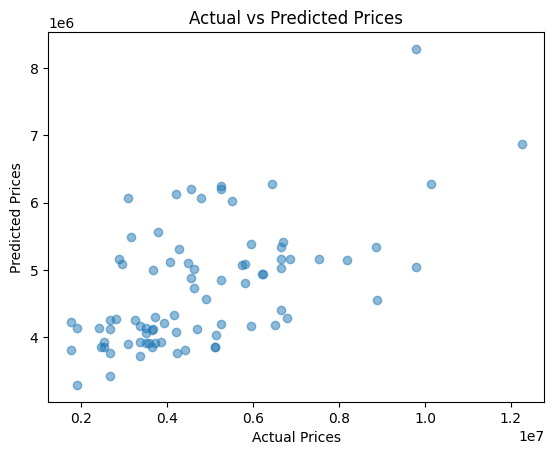

In [35]:
# Visualize the predictions vs actual values
y_pred_test_rescaled = y_scaler.inverse_transform(y_pred_test.numpy())  # Rescale the predictions
y_test_rescaled = y_scaler.inverse_transform(y_test.numpy())  # Rescale the true values

# Plot actual vs predicted prices
plt.scatter(y_test_rescaled, y_pred_test_rescaled, alpha=0.5)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices')
plt.show()


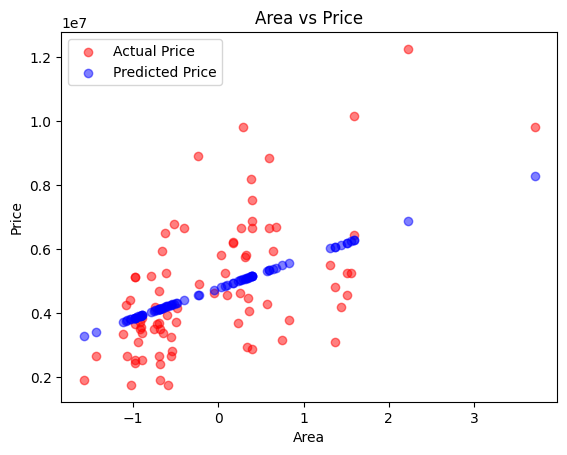

In [36]:
area_test = X_test[:, 0].numpy()

# Scatter plot of area vs actual prices (red)
plt.scatter(area_test, y_test_rescaled, color='red', label='Actual Price', alpha=0.5)

# Scatter plot of area vs predicted prices (blue)
plt.scatter(area_test, y_pred_test_rescaled, color='blue', label='Predicted Price', alpha=0.5)

plt.title('Area vs Price')
plt.xlabel('Area')
plt.ylabel('Price')
plt.legend()
plt.show()

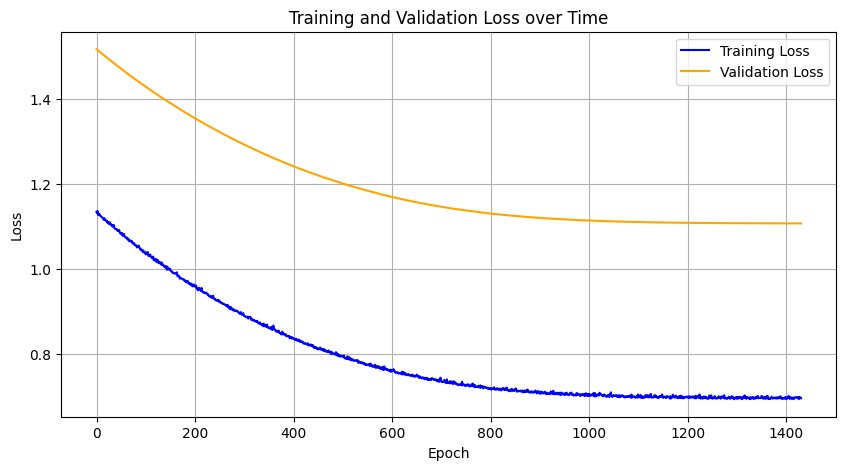

In [37]:
# Plot the training and validation loss over epochs
plt.figure(figsize=(10, 5))  # Set the size of the figure to be 10 inches wide and 5 inches tall
plt.plot(range(len(train_losses)), train_losses, label='Training Loss', color='blue')  # Plot training loss
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss', color='orange')  # Plot validation loss
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Time')
plt.legend()  # Display legend to differentiate between training and validation losses
plt.grid(True)  # Add a grid to the plot for better readability of the loss values
plt.show()  # Display the plot
